1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import norm

In [49]:
N = 1000
mu = 10
sigma = 50

x = np.random.normal(mu, sigma, N)

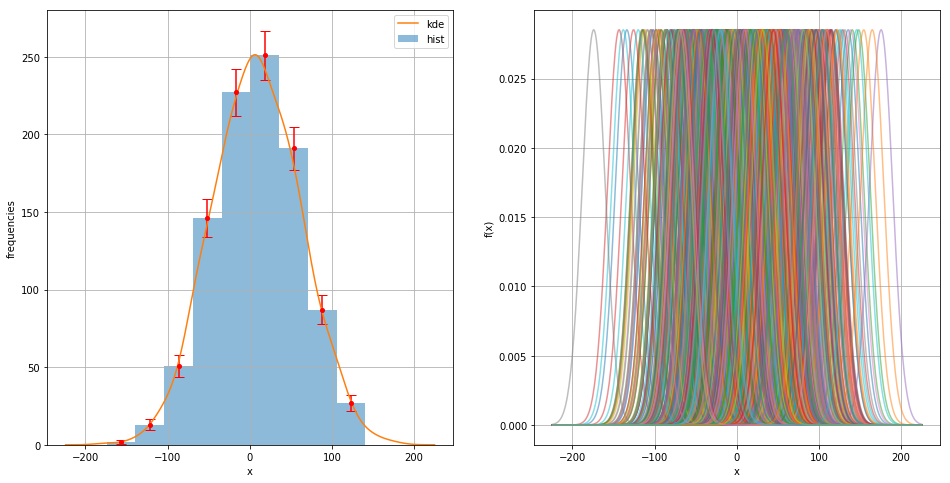

In [87]:
# Create histogram
Nbins = 10

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

freq, bins, patches  = ax1.hist(x, bins=np.arange(x.min(), x.max(), (x.max()-x.min())/Nbins),label='hist', alpha=0.5)
bincenters = (bins[1:] + bins[:-1])/2
ax1.errorbar(x=bincenters, y=freq, yerr=np.sqrt(freq), fmt='o', c='r', marker='o', markersize=4, capsize=5)

ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('frequencies')

# Create Gaussians
std_default = 1.06 * x.std() * (x.size ** -0.2)

xrange = np.arange(x.min()-sigma, x.max()+sigma)
gaussians = []
for i, dat in enumerate(x):
    gaussians.append( norm(loc=dat, scale=std_default).pdf(xrange) )
    ax2.plot(xrange, gaussians[i], alpha=0.5)
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.grid()

# Create KDE
area = integrate.trapz(freq, dx=bins[1]-bins[0])
kde = np.array(gaussians).sum(axis=0)
ax1.plot(xrange, kde/sum(kde)*area, label='kde')
ax1.legend()

plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

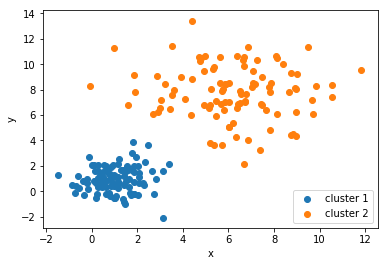

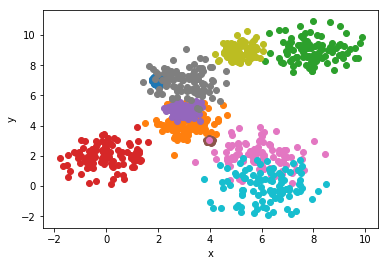

In [90]:
sigma1, sigma2 = 1,2
center1 = (1,1)                                                                                    
center2 = (3,4) 
points = np.random.normal(size=(100,4))
points[:,0] += center1[0]
points[:,1] += center1[1]
points[:,2] += center2[0]
points[:,3] += center2[1]
points[:,:2] *= sigma1
points[:,2:] *= sigma2

plt.scatter(points[:,0], points[:,1], label='cluster 1')
plt.scatter(points[:,2], points[:,3], label='cluster 2')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

n = 10
sigmas = np.random.rand(n)    
centers = np.random.randint(0,10,size=(n, 2))
points = np.random.normal(size=(100, 2*n))
points[:,::2] *= sigmas
points[:,1::2] *= sigmas
points[:,0::2] += centers[:,0]
points[:,1::2] += centers[:,1]
for i in range(n):
    plt.scatter(points[:,i*2],points[:,i*2+1])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

In [113]:
import pandas as pd
import seaborn as sns
import scipy as sc

In [111]:
data = np.load("residuals_261.npy", allow_pickle=True)
df = np.array([data[np.newaxis][0]["residuals"],data[np.newaxis][0]["distances"]]).T
df = pd.DataFrame(df)
df.columns = ["residuals","distances"]
df.describe()

,residuals,distances
count,11131.000000,11131.000000
mean,-0.616477,9.771465
std,4.163705,5.877819
min,-160.850000,0.000000
25%,-0.330000,4.400000
50%,-0.110000,9.700000
75%,0.060000,14.900000
max,11.320000,24.900000


In [112]:
# Clean the samples
df = df[abs(df["residuals"])<2]
df.describe()

,residuals,distances
count,10489.000000,10489.000000
mean,-0.121878,9.954824
std,0.439143,5.847142
min,-2.000000,0.000000
25%,-0.280000,4.700000
50%,-0.100000,10.000000
75%,0.070000,15.100000
max,1.992857,24.900000


In [115]:
# Linear regression
reg = sc.stats.linregress(df["distances"], df["residuals"])

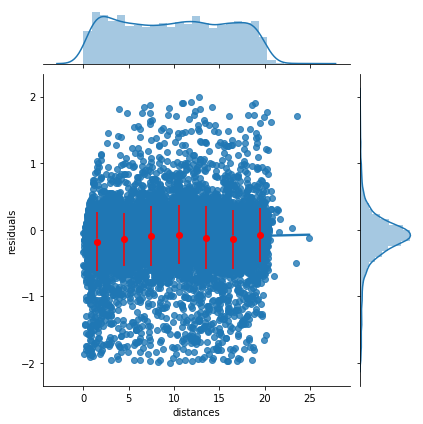

In [116]:
# Plot x, y, res
x = np.linspace(0,21,8)
binned = []
k = 0 
for j in x[1:]: 
    binned.append(df.query("distances<{} & distances>={}".format(j,k))["residuals"].values) 
    k = j 
      
y = list(map(lambda p: p.mean(),binned))
yerr = list(map(lambda p: p.std(),binned))

joint = sns.jointplot("distances", "residuals", data=df, kind="reg")
joint.ax_joint.errorbar((x[:-1]+x[1:])/2, y, yerr=yerr, fmt='o', c='r')

plt.show()